<a href="https://colab.research.google.com/github/aidanvu1992/DS-Unit-2-Applied-Modeling/blob/master/Anh_Vu_DS_Sprint_Challenge_7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

_Lambda School Data Science, Unit 2_

# Applied Modeling Sprint Challenge: Predict Chicago food inspections 🍕

For this Sprint Challenge, you'll use a dataset with information from inspections of restaurants and other food establishments in Chicago from January 2010 to March 2019. 

[See this PDF](https://data.cityofchicago.org/api/assets/BAD5301B-681A-4202-9D25-51B2CAE672FF) for descriptions of the data elements included in this dataset.

According to [Chicago Department of Public Health — Food Protection Services](https://www.chicago.gov/city/en/depts/cdph/provdrs/healthy_restaurants/svcs/food-protection-services.html), "Chicago is home to 16,000 food establishments like restaurants, grocery stores, bakeries, wholesalers, lunchrooms, mobile food vendors and more. Our business is food safety and sanitation with one goal, to prevent the spread of food-borne disease. We do this by inspecting food businesses, responding to complaints and food recalls." 

#### Your challenge: Predict whether inspections failed

The target is the `Fail` column.

- When the food establishment failed the inspection, the target is `1`.
- When the establishment passed, the target is `0`.

#### Run this cell to install packages in Colab:

In [0]:
%%capture
import sys

if 'google.colab' in sys.modules:
    # Install packages in Colab
    !pip install category_encoders==2.*
    !pip install eli5
    !pip install pandas-profiling==2.*
    !pip install pdpbox
    !pip install shap

#### Run this cell to load the data:

In [0]:
import pandas as pd

train_url = 'https://drive.google.com/uc?export=download&id=13_tP9JpLcZHSPVpWcua4t2rY44K_s4H5'
test_url  = 'https://drive.google.com/uc?export=download&id=1GkDHjsiGrzOXoF_xcYjdzBTSjOIi3g5a'

train = pd.read_csv(train_url)
test  = pd.read_csv(test_url)

assert train.shape == (51916, 17)
assert test.shape  == (17306, 17)

In [3]:
print(train.shape)

(51916, 17)


In [4]:
train.head()

,Inspection ID,DBA Name,AKA Name,License #,Facility Type,Risk,Address,City,State,Zip,Inspection Date,Inspection Type,Violations,Latitude,Longitude,Location,Fail
0,2088270,"TOM YUM RICE & NOODLE, INC.",TOM YUM CAFE,2354911.0,Restaurant,Risk 1 (High),608 W BARRY,CHICAGO,IL,60657.0,2017-09-15T00:00:00,Canvass,3. POTENTIALLY HAZARDOUS FOOD MEETS TEMPERATUR...,41.938007,-87.644755,"{'longitude': '-87.6447545707008', 'latitude':...",1
1,555268,FILLING STATION & CONVENIENCE STORE,FILLING STATION & CONVENIENCE STORE,1044901.0,Grocery Store,Risk 3 (Low),6646-6658 S WESTERN AVE,CHICAGO,IL,60636.0,2011-10-20T00:00:00,Complaint Re-Inspection,32. FOOD AND NON-FOOD CONTACT SURFACES PROPERL...,41.772402,-87.683603,"{'longitude': '-87.68360273081268', 'latitude'...",0
2,1751394,A P DELI,A P DELI,47405.0,Restaurant,Risk 1 (High),2025 E 75TH ST,CHICAGO,IL,60649.0,2016-04-05T00:00:00,Canvass Re-Inspection,"35. WALLS, CEILINGS, ATTACHED EQUIPMENT CONSTR...",41.758779,-87.575054,"{'longitude': '-87.57505446746121', 'latitude'...",0
3,1763905,FRANK'S CHICAGO SHRIMP HOUSE,FRANK'S CHICAGO SHRIMP HOUSE,6414.0,Restaurant,Risk 2 (Medium),4459 S ARCHER AVE,CHICAGO,IL,60632.0,2016-04-29T00:00:00,Canvass,38. VENTILATION: ROOMS AND EQUIPMENT VENTED AS...,41.812181,-87.707125,"{'longitude': '-87.70712481334274', 'latitude'...",0
4,453326,MORRILL,MORRILL,24571.0,School,Risk 1 (High),6011 S Rockwell (2600W) AVE,CHICAGO,IL,60629.0,2011-01-10T00:00:00,Canvass,"34. FLOORS: CONSTRUCTED PER CODE, CLEANED, GOO...",NaN,NaN,NaN,0


### Part 1: Preprocessing

You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

_To earn a score of 3 for this part, find and explain leakage. The dataset has a feature that will give you an ROC AUC score > 0.90 if you process and use the feature. Find the leakage and explain why the feature shouldn't be used in a real-world model to predict the results of future inspections._

### Part 2: Modeling

**Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.

Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

_To earn a score of 3 for this part, get an ROC AUC test score >= 0.70 (without using the feature with leakage)._


### Part 3: Visualization

Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:

- Confusion Matrix
- Permutation Importances
- Partial Dependence Plot, 1 feature isolation
- Partial Dependence Plot, 2 features interaction
- Shapley Values

_To earn a score of 3 for this part, make four of these visualization types._

In [0]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import pandas_profiling
import category_encoders as ce 
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from xgboost import XGBRegressor, XGBClassifier
from sklearn.metrics import  roc_auc_score


## Part 1: Preprocessing

> You may choose which features you want to use, and whether/how you will preprocess them. If you use categorical features, you may use any tools and techniques for encoding.

In [6]:
# Check for NAN values
train.isnull().sum()

Inspection ID         0
DBA Name              0
AKA Name            623
License #             5
Facility Type       224
Risk                 12
Address               0
City                 53
State                10
Zip                  26
Inspection Date       0
Inspection Type       1
Violations         9655
Latitude            198
Longitude           198
Location            198
Fail                  0
dtype: int64

In [7]:
# Check value of Inspection Type column of train set
train['Inspection Type'].value_counts()

Canvass                                   24170
License                                    7825
Canvass Re-Inspection                      6346
Complaint                                  4948
License Re-Inspection                      3002
Complaint Re-Inspection                    2241
Short Form Complaint                       2103
License-Task Force                          214
Suspected Food Poisoning                    207
Consultation                                189
Tag Removal                                 146
Out of Business                             109
Task Force Liquor 1475                       92
Recent Inspection                            66
Suspected Food Poisoning Re-inspection       58
Complaint-Fire                               51
Short Form Fire-Complaint                    36
Special Events (Festivals)                   21
No Entry                                     21
Package Liquor 1474                          16
Complaint-Fire Re-inspection            

In [0]:
# Data Wrangling
def wrangle(X):

  X = X.copy()

  # Creating Violation Length column 
  X['Violation_length'] = X['Violations'].str.len().astype(float)

  # create year, month column
  X['Inspection Date'] = pd.to_datetime(df['Inspection Date'], infer_datetime_format=True)
  X['Year'] = X['Inspection Date'].dt.year
  X['Month'] = X['Inspection Date'].dt.month

  # Changing the Facility Type column values to 'other' if there are less
  # than 10 instances in the df
  frequencies = X['Facility Type'].value_counts()
  condition = frequencies <= 10
  mask = frequencies[condition].index
  mask_dict = dict.fromkeys(mask, 'other')
  X['Facility Type'] = X['Facility Type'].replace(mask_dict)

  # Changing the Inspection Type column values to 'other' if there are less
  # than 10 instances in the df
  frequencies = X['Inspection Type'].value_counts()
  condition = frequencies <= 10
  mask = frequencies[condition].index
  mask_dict = dict.fromkeys(mask, 'other')
  X['Inspection Type'] = X['Inspection Type'].replace(mask_dict) 

  # Dropping columns that may muddy or overfit the prediction
  X = X.drop(['Inspection ID', 'DBA Name', 'AKA Name', 
                'License #', 'State', 'City', 'Location',
                'Address', 'Zip', 'Inspection Date', 'Violations'], axis=1)

  return df

In [0]:
# Wrangle data sets
train = wrangle(train)
test = wrangle(test)

In [11]:
print(train.shape, test.shape)

(51916, 9) (17306, 9)


In [0]:
# Target
target = 'Fail'

# Get a dataframe with all train columns except the target
train_features = train.drop(columns=[target])

# Get a list of the numeric features
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get a series with the cardinality of the nonnumeric features
cardinality = train_features.select_dtypes(exclude='number').nunique()

# Get a list of all categorical features with cardinality <= 50
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Combine the lists 
features = numeric_features + categorical_features

In [15]:
# Train / Val split 
train, val = train_test_split(train, test_size=len(test),  
                              stratify=train[target], random_state=42)

train.shape, val.shape, test.shape

((34610, 9), (17306, 9), (17306, 9))

In [0]:
# Arrange data into X features matrix and y target vector
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]
X_test = test[features]
y_test = test[target]

## Part 2: Modeling

> **Fit a model** with the train set. (You may use scikit-learn, xgboost, or any other library.) Use cross-validation or do a three-way split (train/validate/test) and **estimate your ROC AUC** validation score.
>
> Use your model to **predict probabilities** for the test set. **Get an ROC AUC test score >= 0.60.**

In [19]:
random_forest = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median'),
    RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
)

param = {
    'simpleimputer__strategy': ['median'],
    'randomforestclassifier__n_estimators': [150, 200, 220, 230],
    'randomforestclassifier__bootstrap': [True],
    'randomforestclassifier__max_depth': [10,20,25, 30],
    'randomforestclassifier__min_samples_leaf': [1,3],
    'randomforestclassifier__min_samples_split': [4,5,6,7,8]
}

search = RandomizedSearchCV(
    random_forest, 
    param_distributions=param, 
    random_state=44,
    n_iter=5, 
    cv=4, 
    scoring= 'accuracy', 
    verbose=10, 
    return_train_score=True, 
    n_jobs=-1
)


# Fit on train, score on val
search.fit(X_train, y_train)
print('Best hyperparameters', search.best_params_)
print('Cross-validation Accuracy', -search.best_score_)

Fitting 4 folds for each of 5 candidates, totalling 20 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   13.1s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   24.6s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:   51.6s
[Parallel(n_jobs=-1)]: Done  14 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.7min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done  20 out of  20 | elapsed:  1.7min finished


Best hyperparameters {'simpleimputer__strategy': 'median', 'randomforestclassifier__n_estimators': 230, 'randomforestclassifier__min_samples_split': 8, 'randomforestclassifier__min_samples_leaf': 3, 'randomforestclassifier__max_depth': 30, 'randomforestclassifier__bootstrap': True}
Cross-validation Accuracy -0.849783299624386


In [27]:
# ROC score
y_pred_proba = search.predict_proba(X_val)[:, 1]
print(roc_auc_score(y_val, y_pred_proba))
search.best_params_

0.8857644773162766


{'randomforestclassifier__bootstrap': True,
 'randomforestclassifier__max_depth': 30,
 'randomforestclassifier__min_samples_leaf': 3,
 'randomforestclassifier__min_samples_split': 8,
 'randomforestclassifier__n_estimators': 230,
 'simpleimputer__strategy': 'median'}

## Part 3: Visualization

> Make visualizations for model interpretation. (You may use any libraries.) Choose two of these types:
>
> - Permutation Importances
> - Partial Dependence Plot, 1 feature isolation
> - Partial Dependence Plot, 2 features interaction
> - Shapley Values

In [30]:
# Permutation Importances

import eli5
from eli5.sklearn import PermutationImportance

# Using eli5 to find permutation importances

# transforming data for permuter
transformers = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(strategy='median')
)

X_train_transformed = transformers.fit_transform(X_train)
X_val_transformed = transformers.fit_transform(X_val)

# setting model
model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_train_transformed, y_train)

# setting permuter to permutation importance
permuter = PermutationImportance(
    model, 
    scoring='accuracy',
    n_iter=3,
    random_state=42
)

# fitting the data
permuter.fit(X_val_transformed, y_val)
feature_names = X_val.columns.tolist()

eli5.show_weights(
    permuter,
    top=None,
    feature_names = feature_names
)

Weight,Feature
0.1863 ± 0.0020,Violation_length
0.0352 ± 0.0026,Inspection Type
0.0241 ± 0.0009,Year
0.0094 ± 0.0007,Latitude
0.0080 ± 0.0024,Longitude
0.0050 ± 0.0028,Risk
0.0047 ± 0.0017,Month
0.0040 ± 0.0008,Facility Type


In [31]:
train.columns

Index(['Facility Type', 'Risk', 'Inspection Type', 'Latitude', 'Longitude',
       'Fail', 'Violation_length', 'Year', 'Month'],
      dtype='object')

In [34]:
target = 'Fail'
features = train.columns.drop([target])

X = train[features]
y = train[target]

# Use Ordinal Encoder, outside of a pipeline
encoder = ce.OrdinalEncoder()
X_encoded = encoder.fit_transform(X)

model = XGBClassifier(n_estimators=100, random_state=42, n_jobs=-1)
model.fit(X_encoded, y)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=-1,
              nthread=None, objective='binary:logistic', random_state=42,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [0]:
from pdpbox import pdp
from pdpbox.pdp import pdp_plot, pdp_interact, pdp_interact_plot, pdp_isolate

In [0]:
# Create isolated feature
feature='Risk'

isolated = pdp_isolate(
    model = model,
    dataset = X_encoded,
    model_features = X_encoded.columns,
    feature = feature
)

(<Figure size 1080x684 with 2 Axes>,
 {'pdp_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb574f4fa20>,
  'title_ax': <matplotlib.axes._subplots.AxesSubplot at 0x7fb574fe7cf8>})

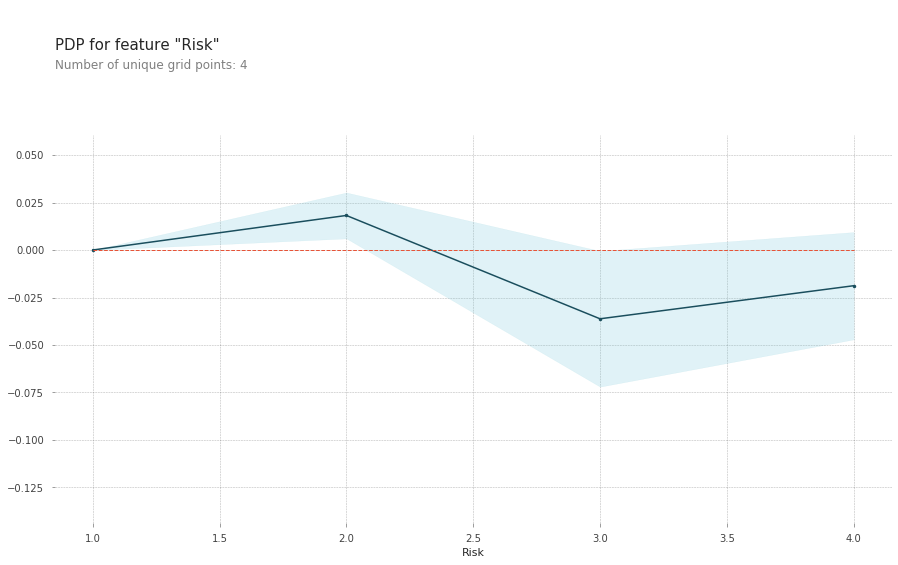

In [51]:
# PDP 1 feature isolation
pdp_plot(isolated, feature_name=feature)

findfont: Font family ['Arial'] not found. Falling back to DejaVu Sans.


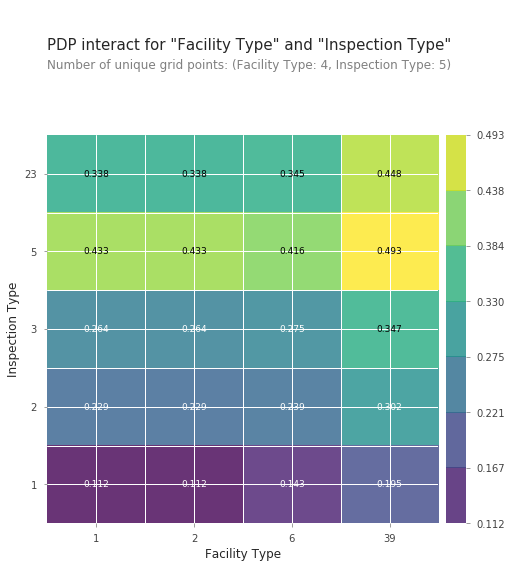

In [42]:
#PDP 2 features interaction
features = ['Facility Type', 'Inspection Type']

interaction = pdp_interact(
    model=model, 
    dataset=X_encoded, 
    model_features=X_encoded.columns, 
    features=features
)

pdp_interact_plot(interaction, plot_type='grid', feature_names=features);